# House Prices Prediction

This notebook walks you through how to train a baseline Random Forest model using TensorFlow Decision Forests on the House Prices dataset made available for this competition.

Roughly, the code will look as follows:

```
import tensorflow_decision_forests as tfdf
import pandas as pd

dataset = pd.read_csv("project/dataset.csv")
tf_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(dataset, label="my_label")

model = tfdf.keras.RandomForestModel()
model.fit(tf_dataset)

print(model.summary())
```

Decision Forests are a family of tree-based models including Random Forests and Gradient Boosted Trees. They are the best place to start when working with tabular data, and will often outperform (or provide a strong baseline) before you begin experimenting with neural networks.

## Import the library

In [1]:
# import tensorflow as tf
# import tensorflow_decision_forests as tfdf
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Comment this if the data visualisations doesn't work on your side
%matplotlib inline

## Load the dataset


In [2]:
# Initializing train dataset
train_file = "train.csv"
train_df = pd.read_csv(train_file)
print("Full train dataset shape is {}".format(train_df.shape))

# Dropping ID column from train dataset
train_df = train_df.drop('Id', axis=1)


# Initializing test dataset

test_file_path = "test.csv"
test_df = pd.read_csv(test_file_path)
print(f"Test dataset shape: {test_df.shape}")

# Stores test IDs

test_ids = test_df['Id']

# Dropping ID column from test dataset
test_df = test_df.drop('Id', axis=1)

Full train dataset shape is (1460, 81)
Test dataset shape: (1459, 80)


The data is composed of 81 columns and 1460 entries. We can see all 81 dimensions of our dataset by printing out the first 3 entries using the following code:

In [3]:
train_df.head(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


* There are 79 feature columns. Using these features your model has to predict the house sale price indicated by the label column named `SalePrice`.

We will drop the `Id` column as it is not necessary for model training.

We can inspect the types of feature columns using the following code:

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [5]:
print("Types of data:\n")
print(train_df.dtypes.value_counts())

Types of data:

object     43
int64      34
float64     3
Name: count, dtype: int64


## House Price Distribution

Now let us take a look at how the house prices are distributed.

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


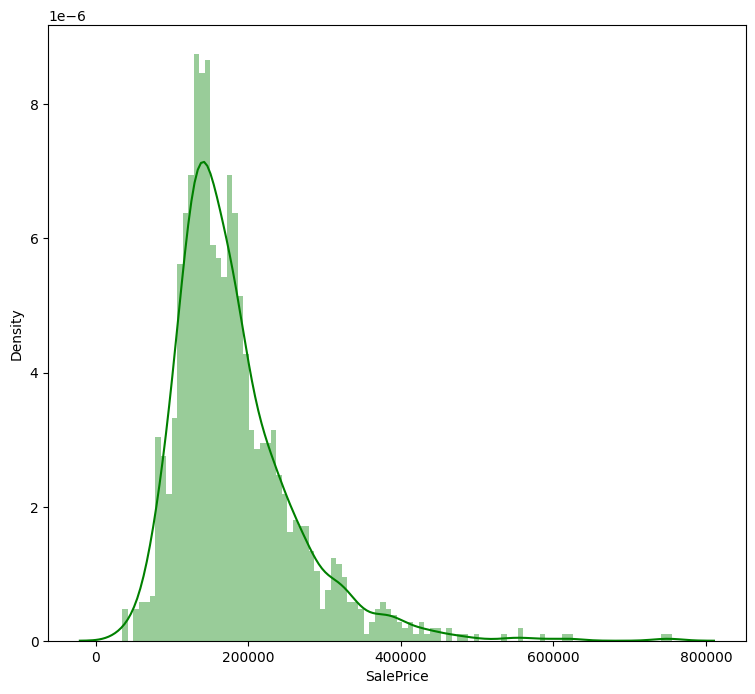

In [6]:
print(train_df['SalePrice'].describe())
plt.figure(figsize=(9, 8))
sns.distplot(train_df['SalePrice'], color='g', bins=100, hist_kws={'alpha': 0.4});

## Numerical data distribution

We will now take a look at how the numerical features are distributed. In order to do this, let us first list all the types of data from our dataset and select only the numerical ones.

In [7]:
list(set(train_df.dtypes.tolist()))

[dtype('int64'), dtype('O'), dtype('float64')]

In [8]:
df_num = train_df.select_dtypes(include = ['float64', 'int64'])
df_num.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,61,0,0,0,0,0,2,2008,208500
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,298,0,0,0,0,0,0,5,2007,181500
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,42,0,0,0,0,0,9,2008,223500
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,35,272,0,0,0,0,2,2006,140000
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,192,84,0,0,0,0,0,12,2008,250000


Now let us plot the distribution for all the numerical features.

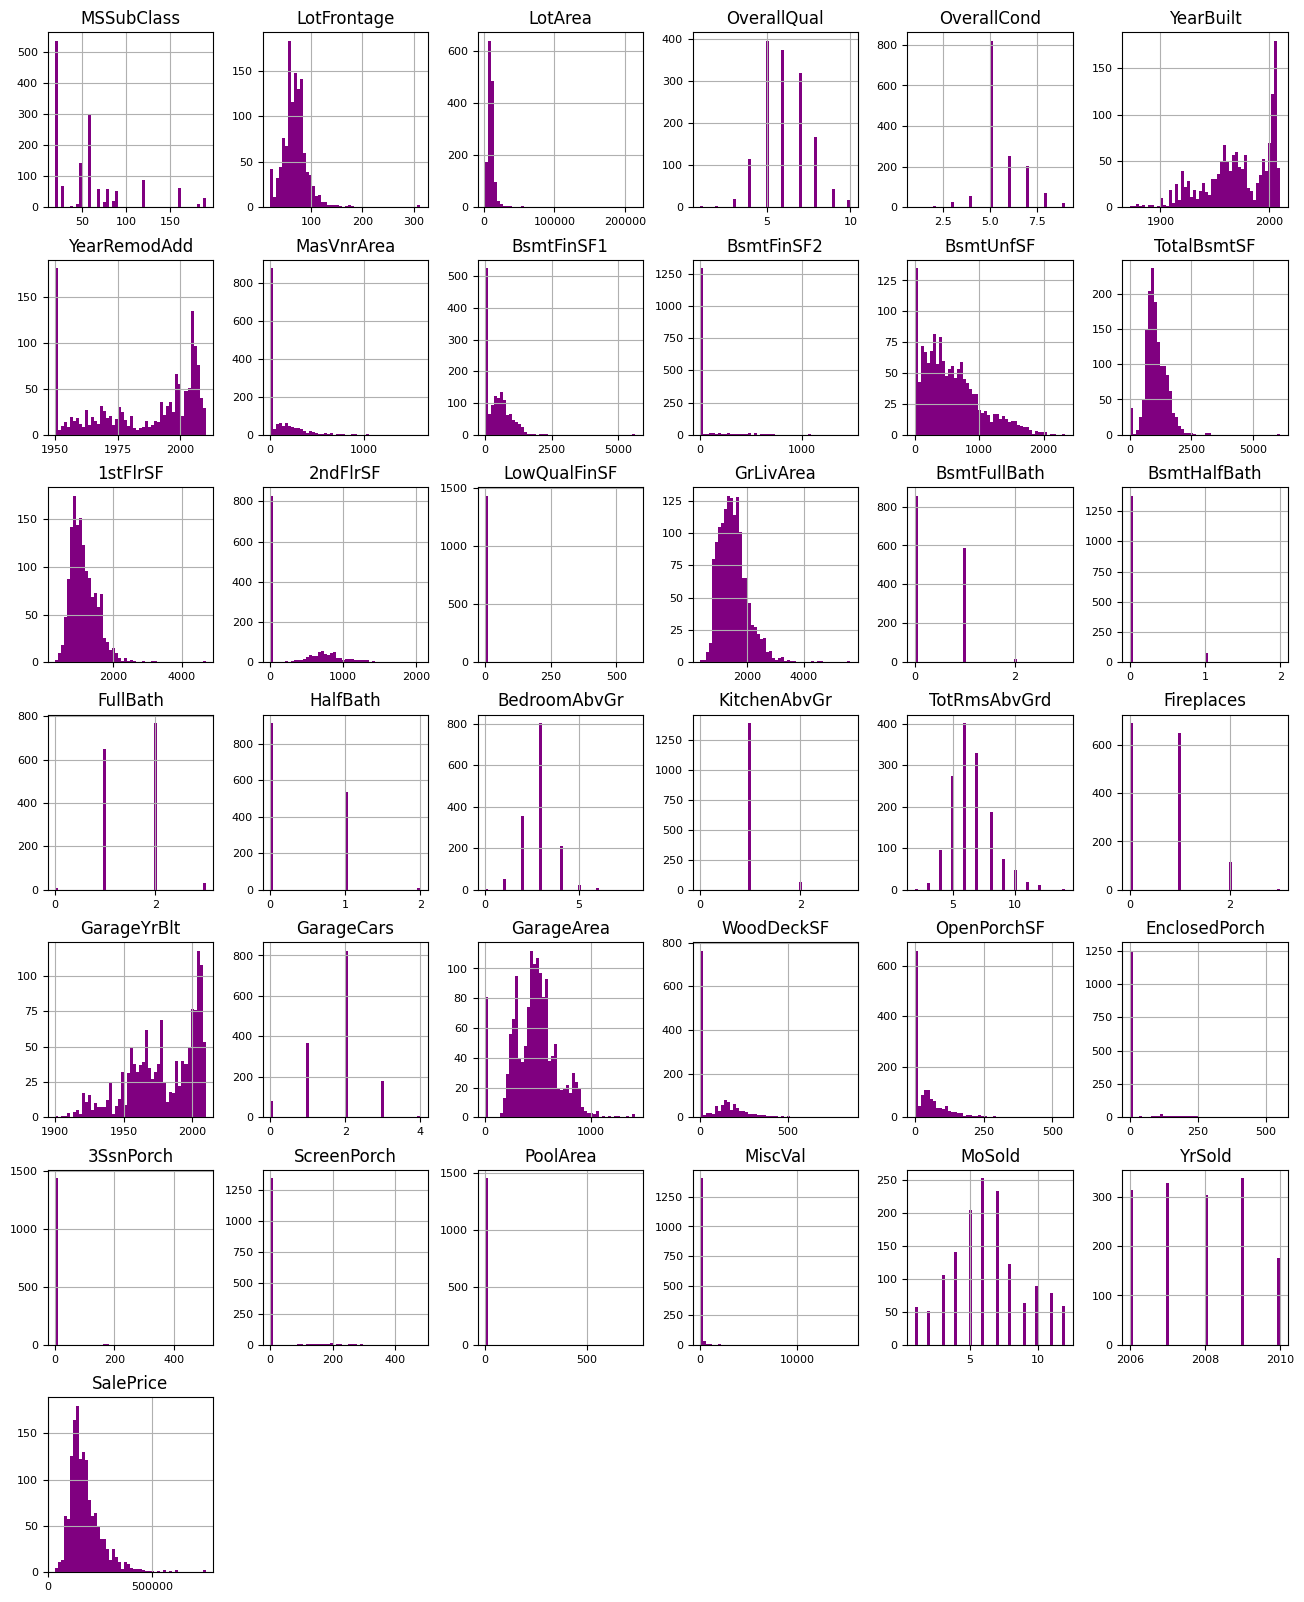

In [9]:
df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8, color= 'purple');

## Missing Values

In [10]:
print("Missing values in each column")
missing_data = train_df.isnull().sum()
print(missing_data[missing_data > 0].sort_values(ascending=False))

Missing values in each column
PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
Electrical         1
dtype: int64


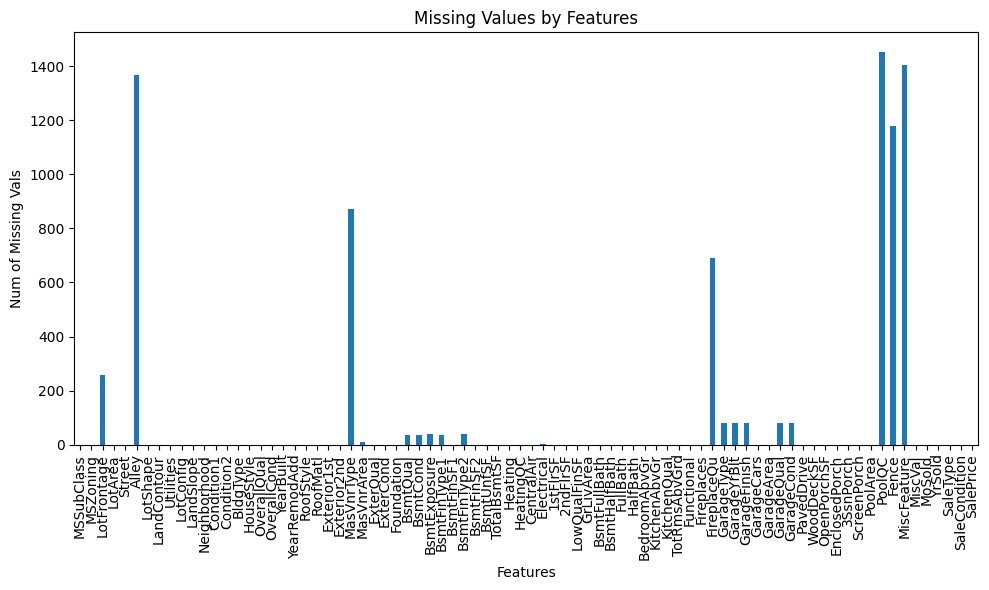

In [11]:
# Visualizing the missing values

plt.figure(figsize=(10, 6))
missing_data.plot(kind="bar")
plt.title("Missing Values by Features")
plt.xlabel("Features")
plt.ylabel("Num of Missing Vals")
plt.tight_layout()
plt.show()

## Correlation With SalePrice

In [12]:
# Finding coorelation between numerical features (int & float) with target feature (SalePrice)
numerical_features = train_df.select_dtypes(include= [np.number]).columns.tolist()

correlation = train_df[numerical_features].corr()['SalePrice'].sort_values(ascending=False)
print(f"Top 10 correlated features:\n{correlation.head(10)}")

Top 10 correlated features:
SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
Name: SalePrice, dtype: float64


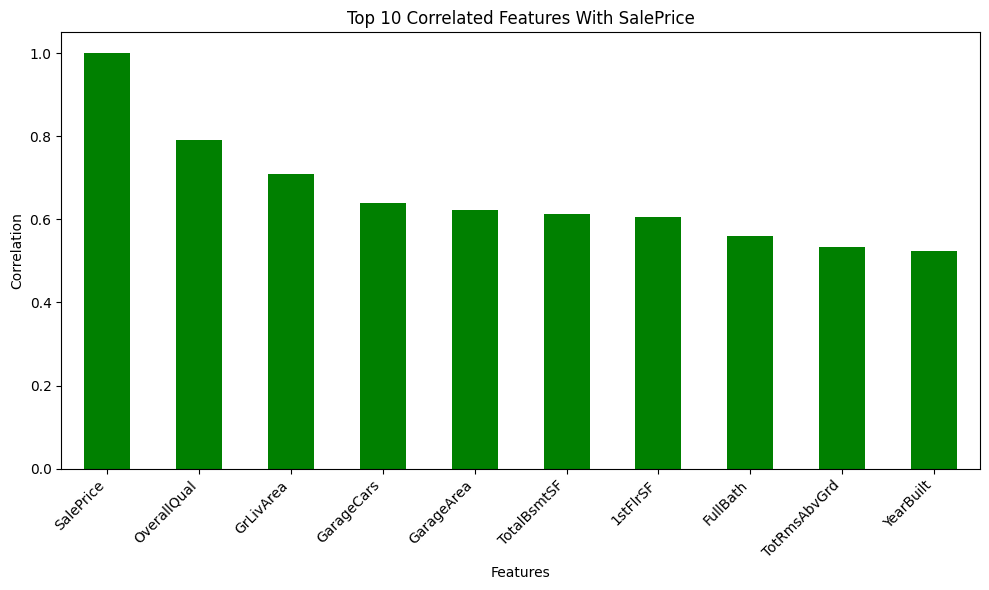

In [13]:
# Visualizing the correlation features with SalePrice

plt.figure(figsize=(10, 6))
correlation.head(10).plot(kind="bar", color= 'green')
plt.title("Top 10 Correlated Features With SalePrice")
plt.xlabel("Features")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Correlation")
plt.tight_layout()
plt.show()

## Data Cleaning And Preprocessing

In [14]:
def preprocess_data(df, is_training = False):

    # Filling LotsFrontage missing data with mean value
    if 'LotFrontage' in df.columns:
        df['LotFrontage'] = df['LotFrontage'].fillna(df['LotFrontage'].mean())

    # Filling BsmtFinType2 missing data with mode value (due to skewness)
    if 'BsmtFinType2' in df.columns:
        df['BsmtFinType2'] = df['BsmtFinType2'].fillna(df['BsmtFinType2'].mode()[0])

    # Filling BsmtFinType1 missing data with mode value (due to skewness)
    if 'BsmtFinType1' in df.columns:
        df['BsmtFinType1'] = df['BsmtFinType1'].fillna(df['BsmtFinType1'].mode()[0])

    # Removing Alley
    if 'Alley' in df.columns: 
        df.drop(['Alley'], axis = 1, inplace = True)

    # Filling MasVnrType missing data with modal value
    if 'MasVnrType' in df.columns:
        df['MasVnrType'] = df['MasVnrType'].fillna(df['MasVnrType'].mode()[0])

    # Filling MasVnrArea missing data with modal value
    if 'MasVnrArea' in df.columns:
        df['MasVnrArea'] = df['MasVnrArea'].fillna(df['MasVnrArea'].mode()[0])

    # Filling GarageQual missing data with modal value
    if 'GarageQual' in df.columns:
        df['GarageQual'] = df['GarageQual'].fillna(df['GarageQual'].mode()[0])

    # Filling missing data in BsmtCond with modal values
    if 'BsmtCond' in df.columns:
        df['BsmtCond'] = df['BsmtCond'].fillna(df['BsmtCond'].mode()[0])

    # Filling missing data in Electrical with modal values
    if 'Electrical' in df.columns:
        df['Electrical'] = df['Electrical'].fillna(df['Electrical'].mode()[0])

    # Filling missing data in BsmtQual with modal values
    if 'BsmtQual' in df.columns:
        df['BsmtQual'] = df['BsmtQual'].fillna(df['BsmtQual'].mode()[0])

    # Removing GarageYrBlt
    if 'GarageYrBlt' in df.columns:
        df.drop(['GarageYrBlt'], axis = 1, inplace = True)

    # Filling missing data in FireplaceQu with modal values
    if 'FireplaceQu' in df.columns:
        df['FireplaceQu'] = df['FireplaceQu'].fillna(df['FireplaceQu'].mode()[0])

    # Filling missing data in GarageType with modal values
    if 'GarageType' in df.columns:
        df['GarageType'] = df['GarageType'].fillna(df['GarageType'].mode()[0])

    # Filling missing data in GarageFinish with modal values
    if 'GarageFinish' in df.columns:
        df['GarageFinish'] = df['GarageFinish'].fillna(df['GarageFinish'].mode()[0])

    # Filling missing data in GarageCond with modal values
    if 'GarageCond' in df.columns:
        df['GarageCond'] = df['GarageCond'].fillna(df['GarageCond'].mode()[0])

    # Filling missing data in GarageCond with modal values
    if 'BsmtExposure' in df.columns:
        df['BsmtExposure'] = df['BsmtExposure'].fillna(df['BsmtExposure'].mode()[0])

    df.drop(['PoolQC', 'Fence', 'MiscFeature'], axis=1, inplace=True)

    # For Test Dataset:
    
    # Filling missing data in BsmtHalfBath with modal values
    if 'BsmtHalfBath' in df.columns:
        df['BsmtHalfBath'] = df['BsmtHalfBath'].fillna(df['BsmtHalfBath'].mode()[0])

    # Filling missing data in BsmtFullBath with modal values
    if 'BsmtFullBath' in df.columns:
        df['BsmtFullBath'] = df['BsmtFullBath'].fillna(df['BsmtFullBath'].mode()[0])

    # Filling missing data in BsmtFinSF1 with modal values
    if 'BsmtFinSF1' in df.columns:
        df['BsmtFinSF1'] = df['BsmtFinSF1'].fillna(df['BsmtFinSF1'].mode()[0])

    # Filling missing data in BsmtFinSF2 with modal values
    if 'BsmtFinSF2' in df.columns:
        df['BsmtFinSF2'] = df['BsmtFinSF2'].fillna(df['BsmtFinSF2'].mode()[0])

    # Filling missing data in TotalBsmtSF with modal values
    if 'TotalBsmtSF' in df.columns:
        df['TotalBsmtSF'] = df['TotalBsmtSF'].fillna(df['TotalBsmtSF'].mode()[0])

    # Filling missing data in BsmtUnfSF with modal values
    if 'BsmtUnfSF' in df.columns:
        df['BsmtUnfSF'] = df['BsmtUnfSF'].fillna(df['BsmtUnfSF'].mode()[0])

    # Filling missing data in GarageCars with modal values
    if 'GarageCars' in df.columns:
        df['GarageCars'] = df['GarageCars'].fillna(df['GarageCars'].mode()[0])

    # Filling missing data in GarageArea with modal values
    if 'GarageArea' in df.columns:
        df['GarageArea'] = df['GarageArea'].fillna(df['GarageArea'].mode()[0])
        
    return df

In [15]:
#  Preprocessing training dataset

train_processed = preprocess_data(train_df, is_training=True)

In [16]:
# Preprocessing testing dataset

test_processed = preprocess_data(test_df, is_training=False)

In [17]:
# Processed datasets info for comparison

train_processed.info(), train_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 75 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1460 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   LotShape       1460 non-null   object 
 6   LandContour    1460 non-null   object 
 7   Utilities      1460 non-null   object 
 8   LotConfig      1460 non-null   object 
 9   LandSlope      1460 non-null   object 
 10  Neighborhood   1460 non-null   object 
 11  Condition1     1460 non-null   object 
 12  Condition2     1460 non-null   object 
 13  BldgType       1460 non-null   object 
 14  HouseStyle     1460 non-null   object 
 15  OverallQual    1460 non-null   int64  
 16  OverallCond    1460 non-null   int64  
 17  YearBuilt      1460 non-null   int64  
 18  YearRemo

(None, None)

In [18]:
# Revising missing data in each column for the processed dataset

missing_data = train_processed.isnull().sum()
print(missing_data[missing_data > 0].sort_values(ascending=False))

Series([], dtype: int64)


In [19]:
# Handling Categorical Feature

categorical_columns = ['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood',
                      'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
                      'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
                      'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
                      'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
                      'PavedDrive', 'SaleType', 'SaleCondition']


label_encoders = {}

for field in categorical_columns:
    if field != 'SalePrice':
        le = LabelEncoder()
        
        # Fit on combined data to ensure consistent encoding
        combined_values = pd.concat([train_processed[field], test_processed[field]], axis=0)
        le.fit(combined_values)
        
        train_processed[field] = le.transform(train_processed[field])
        test_processed[field] = le.transform(test_processed[field])
        
        label_encoders[field] = le

print("Data preprocessing completed...")

Data preprocessing completed...


In [20]:
# Re-processed datasets info for comparison

train_processed.info(), test_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 75 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   int32  
 2   LotFrontage    1460 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   int32  
 5   LotShape       1460 non-null   int32  
 6   LandContour    1460 non-null   int32  
 7   Utilities      1460 non-null   int32  
 8   LotConfig      1460 non-null   int32  
 9   LandSlope      1460 non-null   int32  
 10  Neighborhood   1460 non-null   int32  
 11  Condition1     1460 non-null   int32  
 12  Condition2     1460 non-null   int32  
 13  BldgType       1460 non-null   int32  
 14  HouseStyle     1460 non-null   int32  
 15  OverallQual    1460 non-null   int64  
 16  OverallCond    1460 non-null   int64  
 17  YearBuilt      1460 non-null   int64  
 18  YearRemo

(None, None)

## Prepare the dataset

This dataset contains a mix of numeric, categorical and missing features. TF-DF supports all these feature types natively, and no preprocessing is required. This is one advantage of tree-based models, making them a great entry point to Tensorflow and ML.

In [21]:
# Revising missing data in each column for the processed dataset

missing_data = test_processed.isnull().sum()
print(missing_data[missing_data > 0].sort_values(ascending=False))

Series([], dtype: int64)


In [22]:
# Checking datasets shapes

print("Train dataset shape is {}".format(train_processed.shape))
print("Test dataset shape is {}".format(test_processed.shape))

Train dataset shape is (1460, 75)
Test dataset shape is (1459, 74)


In [23]:
# Prepare descriptive features and target features
desc_feat = train_processed.drop('SalePrice', axis=1)
targ_feat = train_processed['SalePrice']

Now let us split the dataset into training and testing datasets:

In [24]:
# Function for train-test-split (80:20)

d_train, d_val, t_train, t_val = train_test_split(desc_feat, targ_feat, test_size=0.2, random_state=23)

In [25]:
def rmse_score(t_true, t_pred):
    """Calculates Root Mean Squared Error (RMSE)"""
    return math.sqrt(mean_squared_error(t_true, t_pred))

## Training Bottomline Models

### Random Forest Bottom Line Model

In [26]:
# Random Forest model
rf_bl = RandomForestRegressor()

In [27]:
print("Training Random Forest model...")
rf_bl.fit(d_train, t_train)

Training Random Forest model...


,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [28]:
# Validating model

rf_bl_preds = rf_bl.predict(d_val)
rf_bl_rmse = rmse_score(t_val, rf_bl_preds)

#### Feature importance analysis

In [29]:
feature_importance = pd.DataFrame({'feature': desc_feat.columns,'importance': rf_bl.feature_importances_}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features for RF Bottomline Model:")
print(feature_importance.head(10))


Top 10 Most Important Features for RF Bottomline Model:
        feature  importance
15  OverallQual    0.577853
44    GrLivArea    0.108497
42     2ndFlrSF    0.041685
36  TotalBsmtSF    0.035401
41     1stFlrSF    0.023891
32   BsmtFinSF1    0.023834
58   GarageCars    0.015210
59   GarageArea    0.015153
47     FullBath    0.014215
17    YearBuilt    0.011980


### K-Nearest Neighbors Bottom Line Model

In [30]:
# k-NN bottomline model

knn_bl = KNeighborsRegressor()
knn_bl.fit(d_train, t_train)
knn_val_preds = knn_bl.predict(d_val)
knn_bl_rmse = rmse_score(t_val, knn_val_preds)

### Support Vector Machine Bottom Line Model

In [31]:
# SVM bottomline model

svm_bl = SVR()
svm_bl.fit(d_train, t_train)
svm_bl_preds = svm_bl.predict(d_val)
svm_bl_rmse = rmse_score(t_val, svm_bl_preds)

### Gradient Boosting Bottom Line Model

In [36]:
# XGBoost bottomline model

xgb_bl = xgb.XGBRegressor(objective='reg:squarederror')
xgb_bl.fit(d_train, t_train)
xgb_bl_preds = xgb_bl.predict(d_val)
xgb_bl_rmse = np.sqrt(mean_squared_error(t_val, xgb_bl_preds))

### Bottom Line Model Evaluation

In [37]:
bottomline_models = {
    'Random Forest': rf_bl_rmse,
    'k-NN': knn_bl_rmse,
    'SVM': svm_bl_rmse,
    'XGBoost': xgb_bl_rmse
}

print("Bottomline Results:")
for model, score in bottomline_models.items():
    print(f"{model}: {score:.2f} RMSE")

Bottomline Results:
Random Forest: 22640.90 RMSE
k-NN: 36877.44 RMSE
SVM: 72022.10 RMSE
XGBoost: 22695.19 RMSE


## Training Fine Tuned Models

### Random Forest Fine Tuned Model

In [38]:
# Random Forest Hyperparameter tuning

rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}

In [39]:
# Setting up GridSearch Cross Validation

rf_grid = GridSearchCV(
    RandomForestRegressor(random_state=42), 
    rf_params, 
    cv=3, 
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

# Training the fine tuned model

rf_grid.fit(d_train, t_train)

# Finding the best params

rf_best = rf_grid.best_estimator_

# Setting up and training fine tuned model

rf_tuned_preds = rf_best.predict(d_val)
rf_tuned_rmse = rmse_score(t_val, rf_tuned_preds)

### k-NN Fine Tuned Model

In [40]:
# k-NN Hyperparameter tuning

knn_params = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

In [41]:
# Setting up GridSearch Cross Validation

knn_grid = GridSearchCV(
    KNeighborsRegressor(), 
    knn_params, 
    cv=3, 
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

# Training the fine tuned model

knn_grid.fit(d_train, t_train)

# Finding the best params

knn_best = knn_grid.best_estimator_

# Setting up and training fine tuned model

knn_tuned_preds = knn_best.predict(d_val)
knn_tuned_rmse = rmse_score(t_val, knn_tuned_preds)

### SVM Fine Tuned Model

In [42]:
# SVM Hyperparameter tuning

svm_params = {
    'kernel': ['rbf'],
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto']
}

In [43]:
# Setting up GridSearch Cross Validation

svm_grid = GridSearchCV(
    SVR(), 
    svm_params, 
    cv=3, 
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

# Training the fine tuned model

svm_grid.fit(d_train, t_train)

# Finding the best params

svm_best = svm_grid.best_estimator_

# Setting up and training fine tuned model

svm_tuned_preds = svm_best.predict(d_val)
svm_tuned_rmse = rmse_score(t_val, svm_tuned_preds)

### Gradient Boosting Fine Tuned Model

In [45]:
# XGBoost learning parameter tuning

lr = {
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2]
}

xgb_lr = xgb.XGBRegressor(
    n_estimators=100,
    random_state=3,
    objective='reg:squarederror'
)

In [46]:
# Setting up GridSearch Cross Validation

xgb_gridcv = GridSearchCV(
    estimator=xgb_lr,
    param_grid=lr,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

# Training the fine tuned model

xgb_gridcv.fit(d_train, t_train)

# Finding the best params

best_lr = xgb_gridcv.best_params_['learning_rate']

Fitting 3 folds for each of 5 candidates, totalling 15 fits


In [48]:
# Setting up Hyperparameters
xgb_params = {
    'max_depth': [3, 5, 6, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'n_estimators': [100, 200, 300]
}

In [49]:
xgb_tuned = xgb.XGBRegressor(
    learning_rate=best_lr,  # Uses best learning rate from Step 1
    random_state=3,
    objective='reg:squarederror'
)

# Setting up GridSearch Cross Validation

xgb_gridsearch = GridSearchCV(
    estimator=xgb_tuned,
    param_grid=xgb_params,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=2,
    n_jobs=-1
)

In [50]:
# Training the fine tuned model

xgb_gridsearch.fit(d_train, t_train)

# Finding the best params

xgb_best = xgb_gridsearch.best_estimator_

# Setting up and training fine tuned model

xgb_tuned_preds = xgb_best.predict(d_val)
xgb_tuned_rmse = rmse_score(t_val, xgb_tuned_preds)

Fitting 3 folds for each of 324 candidates, totalling 972 fits


### Fine Tuned Model Evaluation

In [52]:
tuned_models = {
    'Random Forest': rf_tuned_rmse,
    'k-NN': knn_tuned_rmse,
    'SVM': svm_tuned_rmse,
    'XGBoost': xgb_tuned_rmse
    
}

print("Fine-tuned Results:")
for model, score in tuned_models.items():
    print(f"{model}: {score:.2f} RMSE")

Fine-tuned Results:
Random Forest: 22215.50 RMSE
k-NN: 33251.47 RMSE
SVM: 71914.20 RMSE
XGBoost: 20776.19 RMSE


## Visualization

In [59]:
comparison_data = []

for model in ['Random Forest', 'k-NN', 'SVM', 'XGBoost']:
    comparison_data.append({
        'Model': model,
        'Type': 'Bottomline',
        'RMSE': bottomline_models[model]
    })
    comparison_data.append({
        'Model': model,
        'Type': 'Fine-tuned',
        'RMSE': tuned_models[model]
    })

# Creating a comparison dataframe
comparison_df = pd.DataFrame(comparison_data)

In [60]:
comparison_df

,Model,Type,RMSE
0,Random Forest,Bottomline,22640.899692
1,Random Forest,Fine-tuned,22215.500581
2,k-NN,Bottomline,36877.435614
3,k-NN,Fine-tuned,33251.468084
4,SVM,Bottomline,72022.103385
5,SVM,Fine-tuned,71914.196144
6,XGBoost,Bottomline,22695.187860
7,XGBoost,Fine-tuned,20776.192529


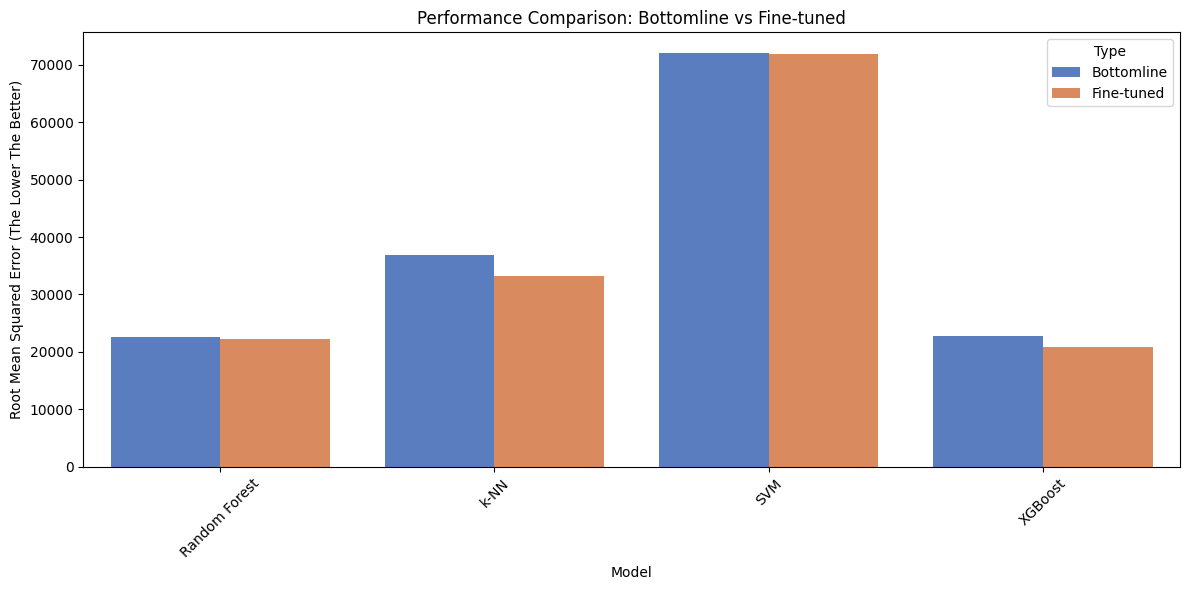

In [61]:
# Model Comparison

plt.figure(figsize=(12, 6))
sns.barplot(data=comparison_df, x='Model', y='RMSE', hue='Type', palette='muted')
plt.title('Performance Comparison: Bottomline vs Fine-tuned')
plt.ylabel('Root Mean Squared Error (The Lower The Better)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Evaluating the best model

In [62]:
all_results = {**bottomline_models, **tuned_models}
best_model_name = min(all_results, key=all_results.get)
best_rmse = all_results[best_model_name]

print(f"\nBest Model: {best_model_name} with RMSE: {best_rmse:.2f}")

# Generate test predictions with best model
if best_model_name == 'Random Forest':
    if rf_tuned_rmse < rf_bl_rmse:
        best_model = rf_best
        print("Using fine-tuned Random Forest")
    else:
        best_model = rf_bl
        print("Using baseline Random Forest")
elif best_model_name == 'k-NN':
    if knn_tuned_rmse < knn_bl_rmse:
        best_model = knn_best
        print("Using fine-tuned k-NN")
    else:
        best_model = knn_bl
        print("Using baseline k-NN")
elif best_model_name == 'XGBoost':
    if xgb_tuned_rmse < xgb_bl_rmse:
        best_model = xgb_best
        print("Using fine-tuned XGBoost")
    else:
        best_model = knn_bl
        print("Using baseline XGBoost")
else:  # SVM
    if svm_tuned_rmse < svm_bl_rmse:
        best_model = svm_best
        print("Using fine-tuned SVM")
    else:
        best_model = svm_bl
        print("Using baseline SVM")

# Generate final predictions
test_predictions = best_model.predict(test_processed)


Best Model: XGBoost with RMSE: 20776.19
Using fine-tuned XGBoost


## Submission

In [63]:
# Create submission file
submission = pd.DataFrame({
    'Id': test_ids,
    'SalePrice': test_predictions
})

# Save submission
print(f"\nPredictions saved to 'house_prices_submission.csv'")
print(f"Best model used: {best_model}")

# Feature importance for Random Forest (if it's the best model)
if 'Random Forest' in best_model_name:
    feature_importance = pd.DataFrame({
        "feature": desc_feat.columns,
        "importance": best_model.feature_importances_
    }).sort_values("importance", ascending=False)
    
    print("\nTop 10 Most Important Features:")
    print(feature_importance.head(10))


Predictions saved to 'house_prices_submission.csv'
Best model used: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.15, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=3, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)
